# Exp 2 – Gradient Boosting Regessor 

##

### 1. Nhập các thư viện cho mô hình

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# nhóm công cụ chia giữ liệu và đánh giá mô hình
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# đánh giá mô hình
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# bỏ qua các thông báo/cảnh báo
import warnings
warnings.filterwarnings('ignore')

### 2. Tải lên file dữ liệu đã qua EDA và Preprocessing

In [2]:
train_path = "../../data/data_afterProcessed/train_processed.csv"
test_path = "../../data/data_afterProcessed/test_processed.csv"
target_path = "../../data/data_afterProcessed/target.csv"

train_processed = pd.read_csv(train_path)
test_processed = pd.read_csv(test_path)
target = pd.read_csv(target_path)

print("Đã tải các tệp dữ liệu đã qua xử lý")

Đã tải các tệp dữ liệu đã qua xử lý


### 3. Logarit hoá biến mục tiêu

In [3]:
y_log = np.log1p(target)
print("Đã log-transform SalePrice")

Đã log-transform SalePrice


##### thay đổi này giúp mô hình học nhanh hơn

### 4. Khởi tạo model với hyperparameters với RandomizedSearchCV

In [4]:
param_dist_gb = {
    'n_estimators': [100, 200, 300, 500, 800, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', 0.5, 0.7, 0.9]  # 'auto' không hợp lệ với GradientBoostingRegressor
}

# Khởi tạo model cơ bản và scorer cho RMSE
gb_base = GradientBoostingRegressor(random_state=25)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

# RandomizedSearchCV
random_search_GB = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist_gb,
    n_iter=50,                      # số combination thử nghiệm
    cv=5,                           # 5-Fold Cross Validation
    scoring=rmse_scorer,
    n_jobs=-1,      
    random_state=25,
    verbose=1
)

# Huấn luyện và kiểm tra kết quả
random_search_GB.fit(train_processed, target.values.ravel())
print("Đã hoàn thành RandomizedSearchCV cho Gradient Boosting")
print(f"Các thông số tốt nhất: {random_search_GB.best_params_}")
print(f"Điểm CV (RMSE) tốt nhất: {-random_search_GB.best_score_:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Đã hoàn thành RandomizedSearchCV cho Gradient Boosting
Các thông số tốt nhất: {'subsample': 0.6, 'n_estimators': 1000, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 4, 'learning_rate': 0.01}
Điểm CV (RMSE) tốt nhất: 0.1135


In [5]:
# Cuối cùng chúng ta huấn luyện mô hình với best parameters
best_params = random_search_GB.best_params_

model_GB = GradientBoostingRegressor(
    n_estimators=best_params.get('n_estimators', 500),
    learning_rate=best_params.get('learning_rate', 0.1),
    max_depth=best_params.get('max_depth', 3),
    min_samples_split=best_params.get('min_samples_split', 2),
    min_samples_leaf=best_params.get('min_samples_leaf', 1),
    subsample=best_params.get('subsample', 1.0),
    max_features=best_params.get('max_features', 'auto'),
    random_state=25,
    verbose=1
)

model_GB.fit(train_processed, target.values.ravel())
print("Đã huấn luyện xong mô hình Gradient Boosting")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1511           0.0023            2.91s
         2           0.1438          -0.0050            2.86s
         3           0.1450           0.0077            2.77s
         4           0.1506           0.0142            2.88s
         5           0.1346          -0.0182            2.81s
         6           0.1456           0.0221            2.82s
         7           0.1416          -0.0006            2.84s
         8           0.1475           0.0143            2.83s
         9           0.1371          -0.0103            2.80s
        10           0.1275          -0.0094            2.78s
        20           0.1160           0.0091            2.56s
        30           0.0995           0.0114            2.50s
        40           0.0844           0.0070            2.45s
        50           0.0725          -0.0042            2.39s
        60           0.0646           0.0014            2.33s
       

### 5. Đánh giá mô hình

In [6]:
# Dự đoán trên tập train
y_pred_train = model_GB.predict(train_processed)

# R² score trên giá trị gốc
r2_original = r2_score(target, y_pred_train)

# Chuyển sang log scale để đánh giá
y_pred_log = np.log1p(y_pred_train)
rmse_log = np.sqrt(mean_squared_error(y_log, y_pred_log))
r2_log = r2_score(y_log, y_pred_log)

print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"R² (log scale): {r2_log:.4f}")
print(f"R² trên tập train (giá trị gốc): {r2_original:.4f}")

RMSE (log scale): 0.0051
R² (log scale): 0.9709
R² trên tập train (giá trị gốc): 0.9715


### 6. Đánh giá về điểm và độ ổn định của các Fold

In [7]:
# Đánh giá độ ổn định với Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=25)
cv_scores_optimized = cross_val_score(
    model_GB, 
    train_processed, 
    target.values.ravel(), 
    cv=kf, 
    scoring=rmse_scorer,
    n_jobs=-1
)
cv_scores_optimized = -cv_scores_optimized

print("Điểm RMSE của từng Fold: ")
for i, score in enumerate(cv_scores_optimized, 1):
    print(f"Fold {i}: RMSE = {score:.4f}")

print(f"RMSE trung bình: {cv_scores_optimized.mean():.4f} (+/- {cv_scores_optimized.std() * 2:.4f})")

Điểm RMSE của từng Fold: 
Fold 1: RMSE = 0.1247
Fold 2: RMSE = 0.1158
Fold 3: RMSE = 0.1100
Fold 4: RMSE = 0.1069
Fold 5: RMSE = 0.1151
RMSE trung bình: 0.1145 (+/- 0.0121)


In [8]:
# Độ ổn định của mô hình 
print(f"RMSE nhỏ nhất: {cv_scores_optimized.min():.4f}")
print(f"RMSE lớn nhất: {cv_scores_optimized.max():.4f}")
print(f"Khoảng biến động: {cv_scores_optimized.max() - cv_scores_optimized.min():.4f}")

if cv_scores_optimized.std() < cv_scores_optimized.mean() * 0.1:
    print("Mô hình tương đối ổn định qua các fold")
else:
    print("Mô hình có độ biến động lớn qua các fold")

RMSE nhỏ nhất: 0.1069
RMSE lớn nhất: 0.1247
Khoảng biến động: 0.0177
Mô hình tương đối ổn định qua các fold


### 7. Tạo file submit bài và lưu file mô hình

In [9]:
test_pred = model_GB.predict(test_processed)

if test_pred.ndim > 1:
    test_pred = test_pred.ravel()
test_pred_final = np.expm1(test_pred)

# Tạo submission file
submission_optimized = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_pred_final)),  
    'SalePrice': test_pred_final
})

submission_optimized.to_csv('result/GB_submission.csv', index=False)
print("Đã tạo file GB_submission.csv")

Đã tạo file GB_submission.csv


In [10]:
joblib.dump(model_GB, 'pkl/GradientBoosting_model.pkl')
print("Đã lưu mô hình Gradient Boosting")

Đã lưu mô hình Gradient Boosting


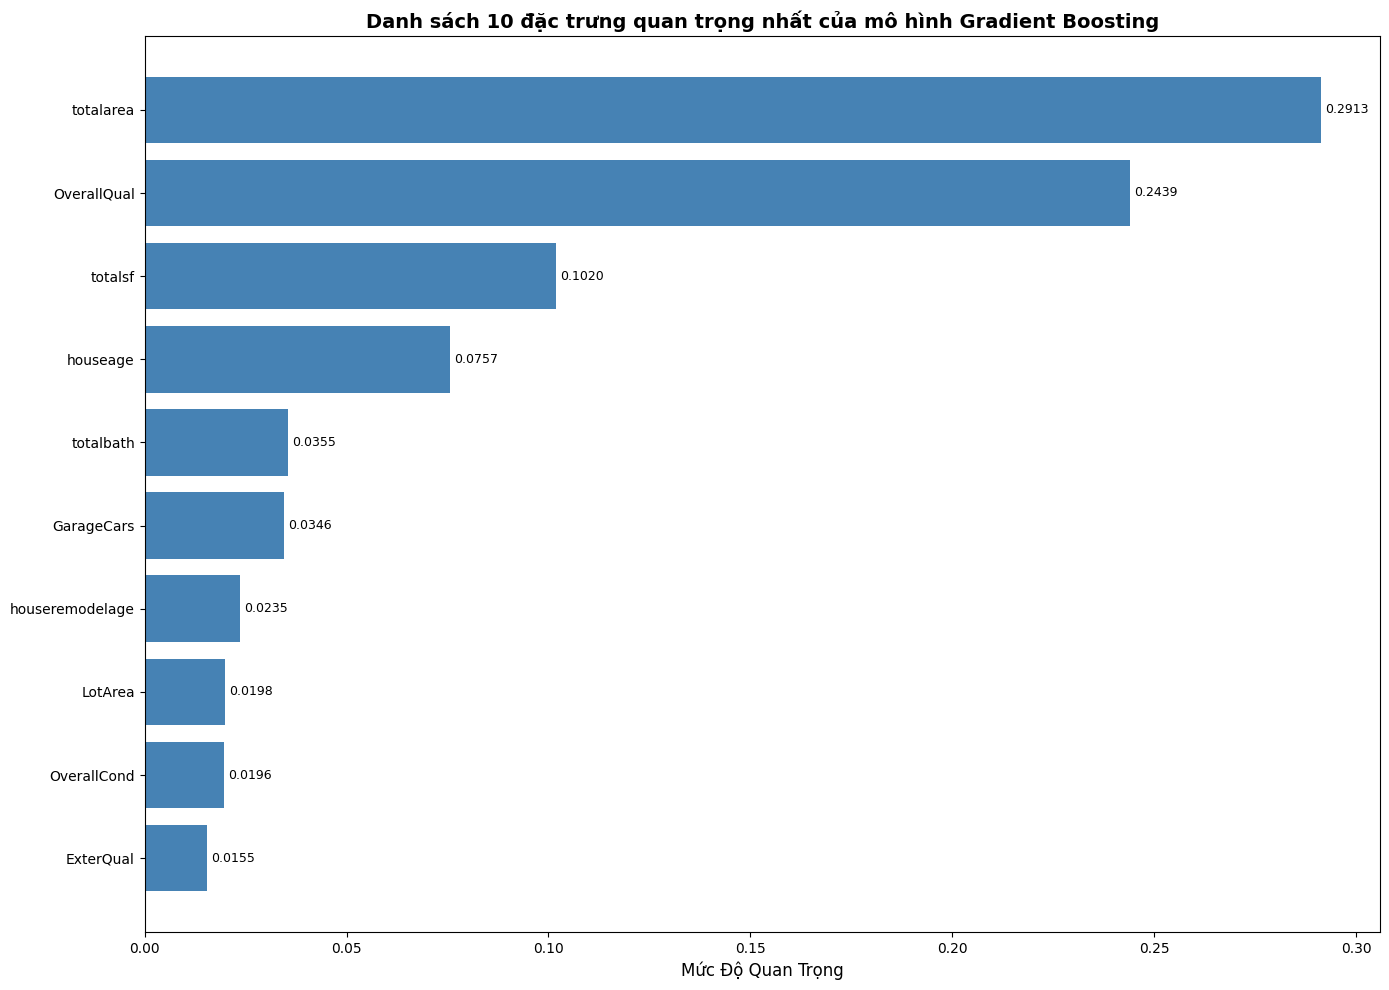

In [11]:
feature_importance = pd.DataFrame({
    'feature': train_processed.columns,
    'importance': model_GB.feature_importances_
}).sort_values('importance', ascending=False)

# Lấy danh sách 10 đặc trưng quan trọng nhất
top_10_features = feature_importance.head(10)
top_10_features_display = top_10_features.iloc[::-1]

# Vẽ biểu đồ 
plt.figure(figsize=(14, 10))
bars = plt.barh(
    top_10_features_display['feature'], 
    top_10_features_display['importance'],
    color='steelblue'
)
plt.title('Danh sách 10 đặc trưng quan trọng nhất của mô hình Gradient Boosting', fontsize=14, fontweight='bold')
plt.xlabel('Mức Độ Quan Trọng', fontsize=12)

# Thêm giá trị trên mỗi cột
for bar, importance in zip(bars, top_10_features_display['importance']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{importance:.4f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()
